<a href="https://colab.research.google.com/github/nathanzilgo/Data-Science-Notebooks/blob/master/Ensemble_Classifica%C3%A7%C3%A3o_de_doen%C3%A7as_card%C3%ADacas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
%%capture
# Read and process data in tabular form
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler

# Pipes
from sklearn.pipeline import Pipeline, make_pipeline

# Data stratification
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, KFold

# Models
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, ExtraTreesClassifier
)

# Fine tuning
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import (
      classification_report, confusion_matrix,
      ConfusionMatrixDisplay, f1_score, precision_score, recall_score,
      PrecisionRecallDisplay)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')
sns.set_context(rc={"patch.force_edgecolor": False, "patch.alpha": 0.1})

# SHAP
!pip install shap

In [ ]:
# Download the file from Google Drive
%%capture

!gdown --id 10Yq-33yf5kSLZpOO6BQvWZzDxddpF-Lr

# EDA
(50%) Realize uma análise exploratória dos dados, identificando e descrevendo:
Metodologia adotada para o tratamento de dados ausentes
Normalização dos dados
Correlação entre as variáveis preditoras e variável-alvo
Balanceamento das classes (variável-alvo) (se necessário)

In [ ]:
dataset = pd.read_csv('heart.csv')
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Distribuição da variável alvo:

<Axes: xlabel='target', ylabel='count'>

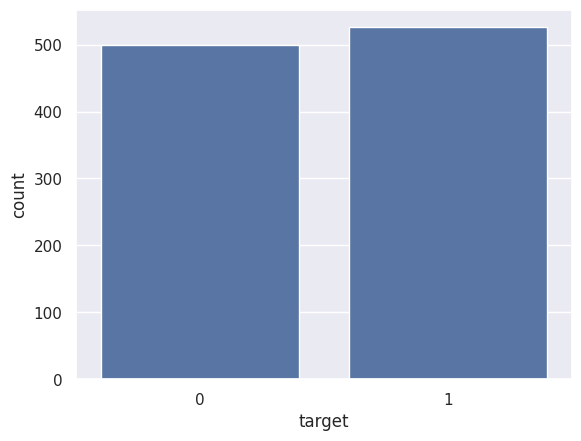

In [ ]:
sns.countplot(x='target', data=dataset)

In [ ]:
# Check for null entries
null_entries = dataset.isnull().sum()

# Make correlations
correlations = dataset.corr()

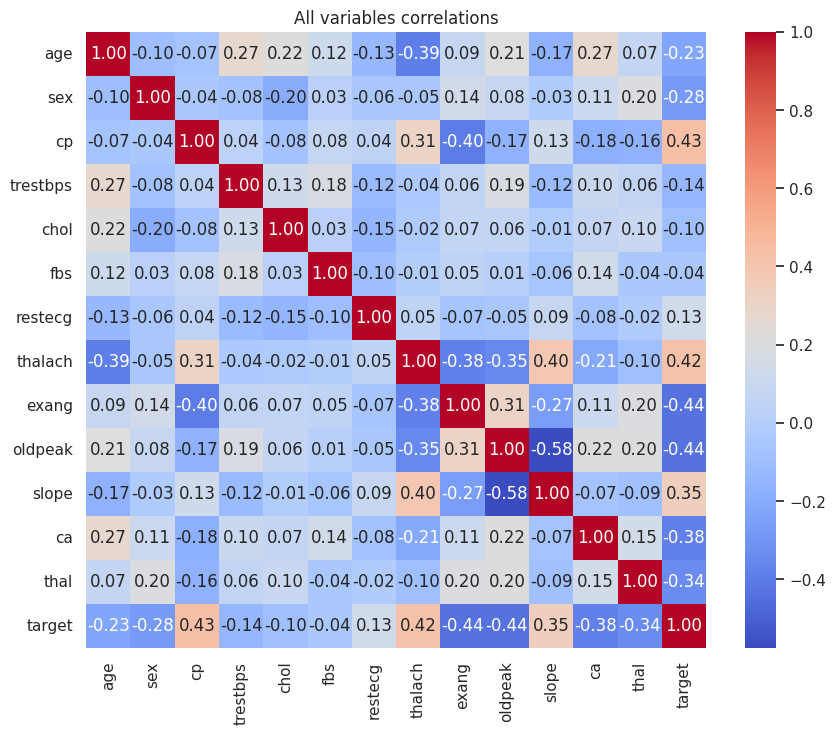

In [ ]:
import matplotlib.pyplot as plt
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('All variables correlations')
plt.show()


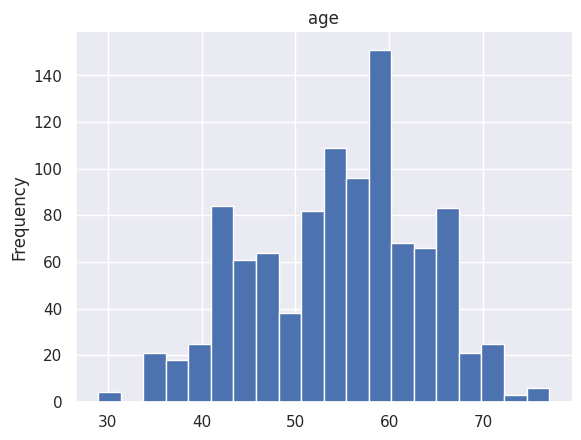

In [ ]:
# @title age

from matplotlib import pyplot as plt
dataset['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Normalizando os dados utilizando StandardScaler:

In [ ]:
# Create a scaler object
scaler = StandardScaler()

# Fit the scaler to the data
scaler.fit(dataset)

# Transform the data
dataset_scaled = scaler.transform(dataset)

Correlação entre age e target:

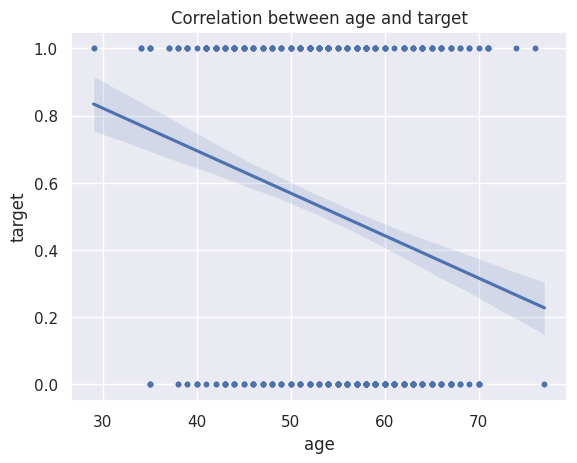

In [ ]:
sns.regplot(x=dataset.age, y=dataset.target, marker='.')
plt.xlabel('age')
plt.ylabel('target')
plt.title('Correlation between age and target')
plt.show()

# Train

(50%) Uma vez pré-processados os dados, você vai treinar e avaliar Random Forests, ExtraTrees, Adaboost e Gradient Boosting para realizar as seguintes atividades:
Faça um fine-tuning dos modelos, considerando os hiperâmetros (e.g., número de modelos base, learning rate, etc.) que achar mais importantes, e compare o desempenho dos modelos usando as métricas que achar mais adequadas. Inclua um baseline que não é ensemble para comparação (por exemplo, regressão logística). Justifique suas escolhas.
Quais as features mais importantes?
Use o próprio modelo para extrair a importância das features
Use SHAP
Em ambos os casos, interprete e compare as saídas de (i) e (ii).



In [ ]:
pipelines = {
    'randomforestclassifier': make_pipeline(StandardScaler(), RandomForestClassifier()),
    'extratreesclassifier': make_pipeline(StandardScaler(), ExtraTreesClassifier()),
    'adaboostclassifier':  make_pipeline(StandardScaler(), AdaBoostClassifier()),
    'gradientboostingclassifier': make_pipeline(GradientBoostingClassifier())
}


## Fine Tuning

Grid params for each ensemble:

In [ ]:
param_grids = {
    'randomforestclassifier': {
        'randomforestclassifier__n_estimators': [250, 500, 750, 1000],
        'randomforestclassifier__max_depth': [5, 10, 20, 30],
        'randomforestclassifier__min_samples_split': [2, 5, 10],
        'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    },
    'extratreesclassifier': {
        'extratreesclassifier__n_estimators': [100, 200, 300, 400, 500],
        'extratreesclassifier__max_depth': [None, 5, 10, 20],
        'extratreesclassifier__min_samples_split': [2, 5, 10],
        'extratreesclassifier__min_samples_leaf': [1, 2, 4],
        'extratreesclassifier__max_features': ['sqrt', 'log2', None]
    },
    'adaboostclassifier': {
        'adaboostclassifier__learning_rate': [0.01, 0.1, 1, 10, 100],
        'adaboostclassifier__n_estimators': [10, 50, 100, 200],
    },
    'gradientboostingclassifier': {
        'gradientboostingclassifier__loss': ['log_loss'],
        'gradientboostingclassifier__learning_rate': [0.01, 0.1, 0.5],
        'gradientboostingclassifier__n_estimators': [30, 50, 100],
        'gradientboostingclassifier__subsample': [0.5, 0.618, 0.8, 1.0],
        # 'gradientboostingclassifier__criterion': ['friedman_mse', 'mse', 'mae'],
        # 'gradientboostingclassifier__min_samples_split': [2, 5, 10],
        # 'gradientboostingclassifier__min_samples_leaf' : [1, 2, 4]
    }
}

In [ ]:
X, y = dataset.drop('target', axis=1), dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
with open('output.txt', 'w') as f:
  for model_name, model in pipelines.items():
      print(f"Tuning hyperparameters for {model_name}", file=f)
      grid_search = GridSearchCV(model, param_grids[model_name], cv=5, refit=True)
      grid_search.fit(X_train, y_train)
      print("Best parameters found:", file=f)
      print(grid_search.best_params_, file=f)
      print("Best cross-validation score:", file=f)
      print(grid_search.best_score_, file=f)
      print("Test set score:", file=f)
      print(grid_search.score(X_test, y_test), file=f)
      print("\n", file=f)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:627: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:627: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:627: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
/usr/

## Metrics

Classification report for randomforestclassifier:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205





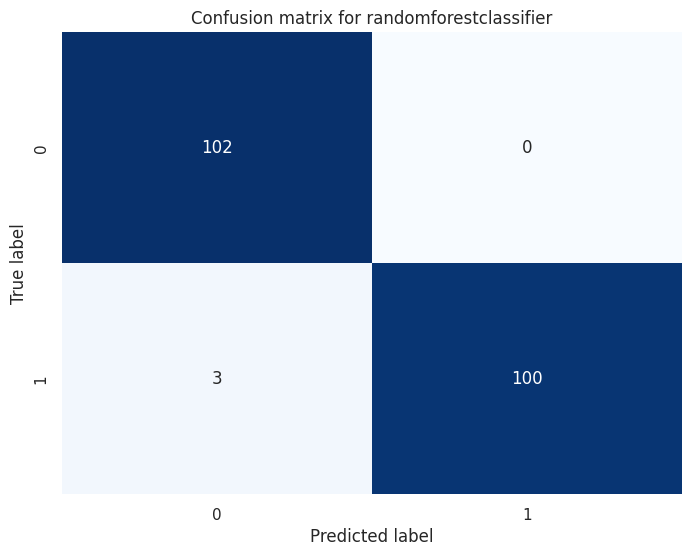

Classification report for extratreesclassifier:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205





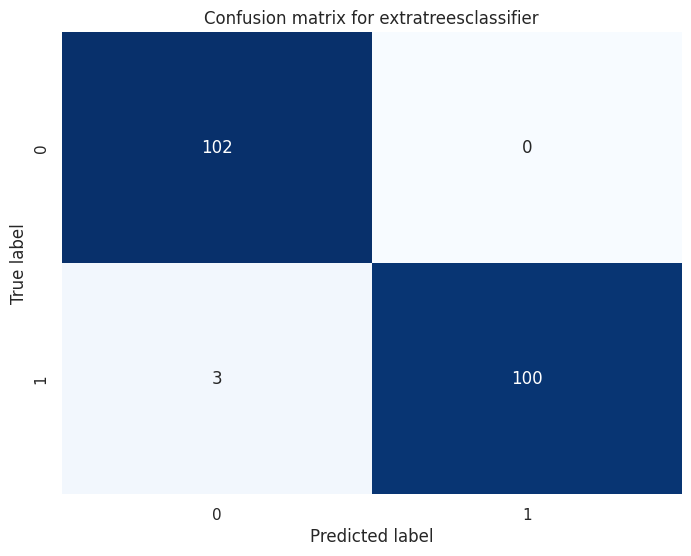

Classification report for adaboostclassifier:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       102
           1       0.89      0.86      0.88       103

    accuracy                           0.88       205
   macro avg       0.88      0.88      0.88       205
weighted avg       0.88      0.88      0.88       205





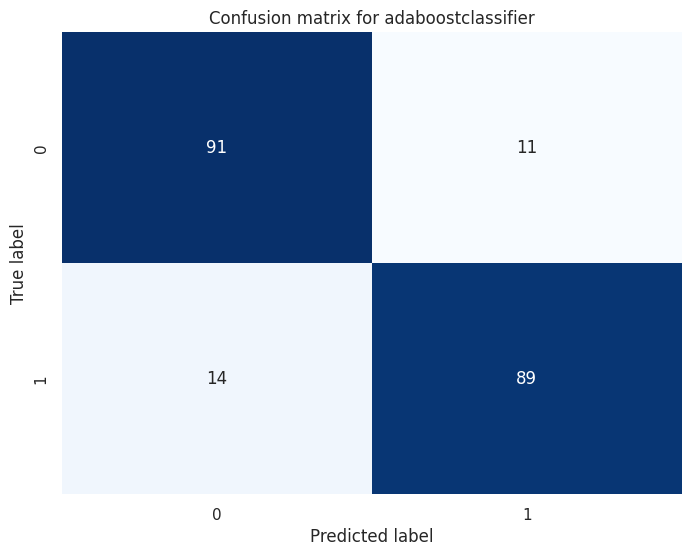

Classification report for gradientboostingclassifier:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       102
           1       0.92      0.95      0.93       103

    accuracy                           0.93       205
   macro avg       0.93      0.93      0.93       205
weighted avg       0.93      0.93      0.93       205





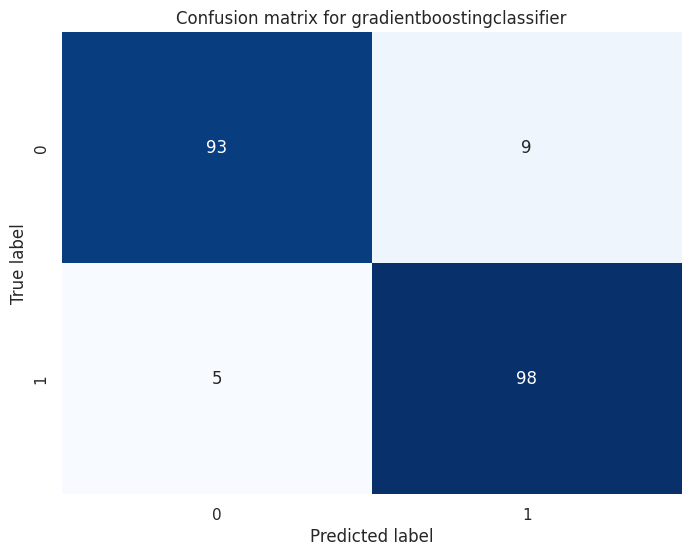

In [ ]:
for model_name, model in pipelines.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Classification report for {model_name}:")
    print(classification_report(y_test, y_pred))
    print("\n")

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Confusion matrix for {model_name}")
    plt.show()



## Comparação com Naive Bayes baseline

Classification report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.87      0.71      0.78       102
           1       0.75      0.89      0.82       103

    accuracy                           0.80       205
   macro avg       0.81      0.80      0.80       205
weighted avg       0.81      0.80      0.80       205



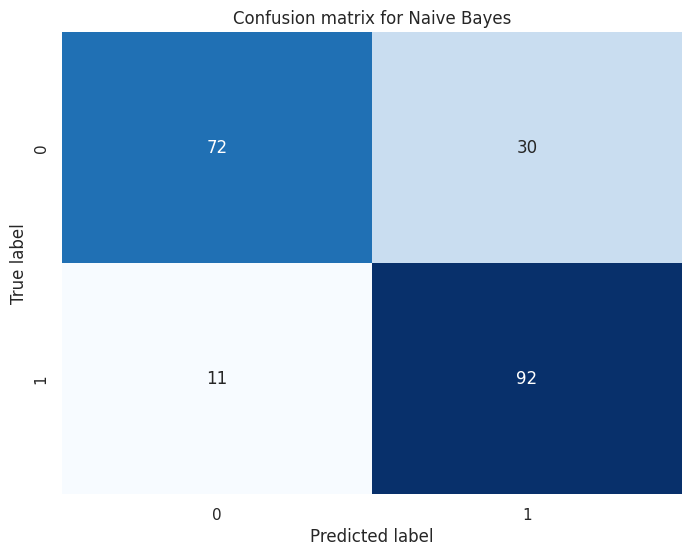

AttributeError: 'Pipeline' object has no attribute 'best_estimator_'

In [ ]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
y_pred_naive_bayes = naive_bayes.predict(X_test)
print("Classification report for Naive Bayes:")
print(classification_report(y_test, y_pred_naive_bayes))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_naive_bayes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix for Naive Bayes")
plt.show()

# Compare the performance of the models
models = {
    'Naive Bayes': naive_bayes,
    #'Random Forest': pipelines['randomforestclassifier'].best_estimator_,
    'Extra Trees': pipelines['extratreesclassifier'].best_estimator_,
    'AdaBoost': pipelines['adaboostclassifier'].best_estimator_,
    'Gradient Boosting': pipelines['gradientboostclassifier'].best_estimator_
}

for model_name, model in models.items():
    print(f"Model: {model_name}")
    print(f"Test score: {model.score(X_test, y_test)}")
    print("\n")

## Feature importance with SHAP

## Feature  Importance sem  Shap

In [ ]:
for model_name, model in pipelines.items():
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print feature ranking
    print(f"Feature ranking for {model_name}:")
    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot feature importances
    plt.figure()
    plt.title(f"Feature importances for {model_name}")
    plt.bar(range(X.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [ ]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(pipelines['randomforestclassifier'].best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")